# 0. Preview

## 1) info

In [28]:
import os
train_data = os.listdir("/home/jovyan/work/prj_data/open/train_img")
print("train이미지 개수:", len(train_data))

train이미지 개수: 7140


## 2) Example

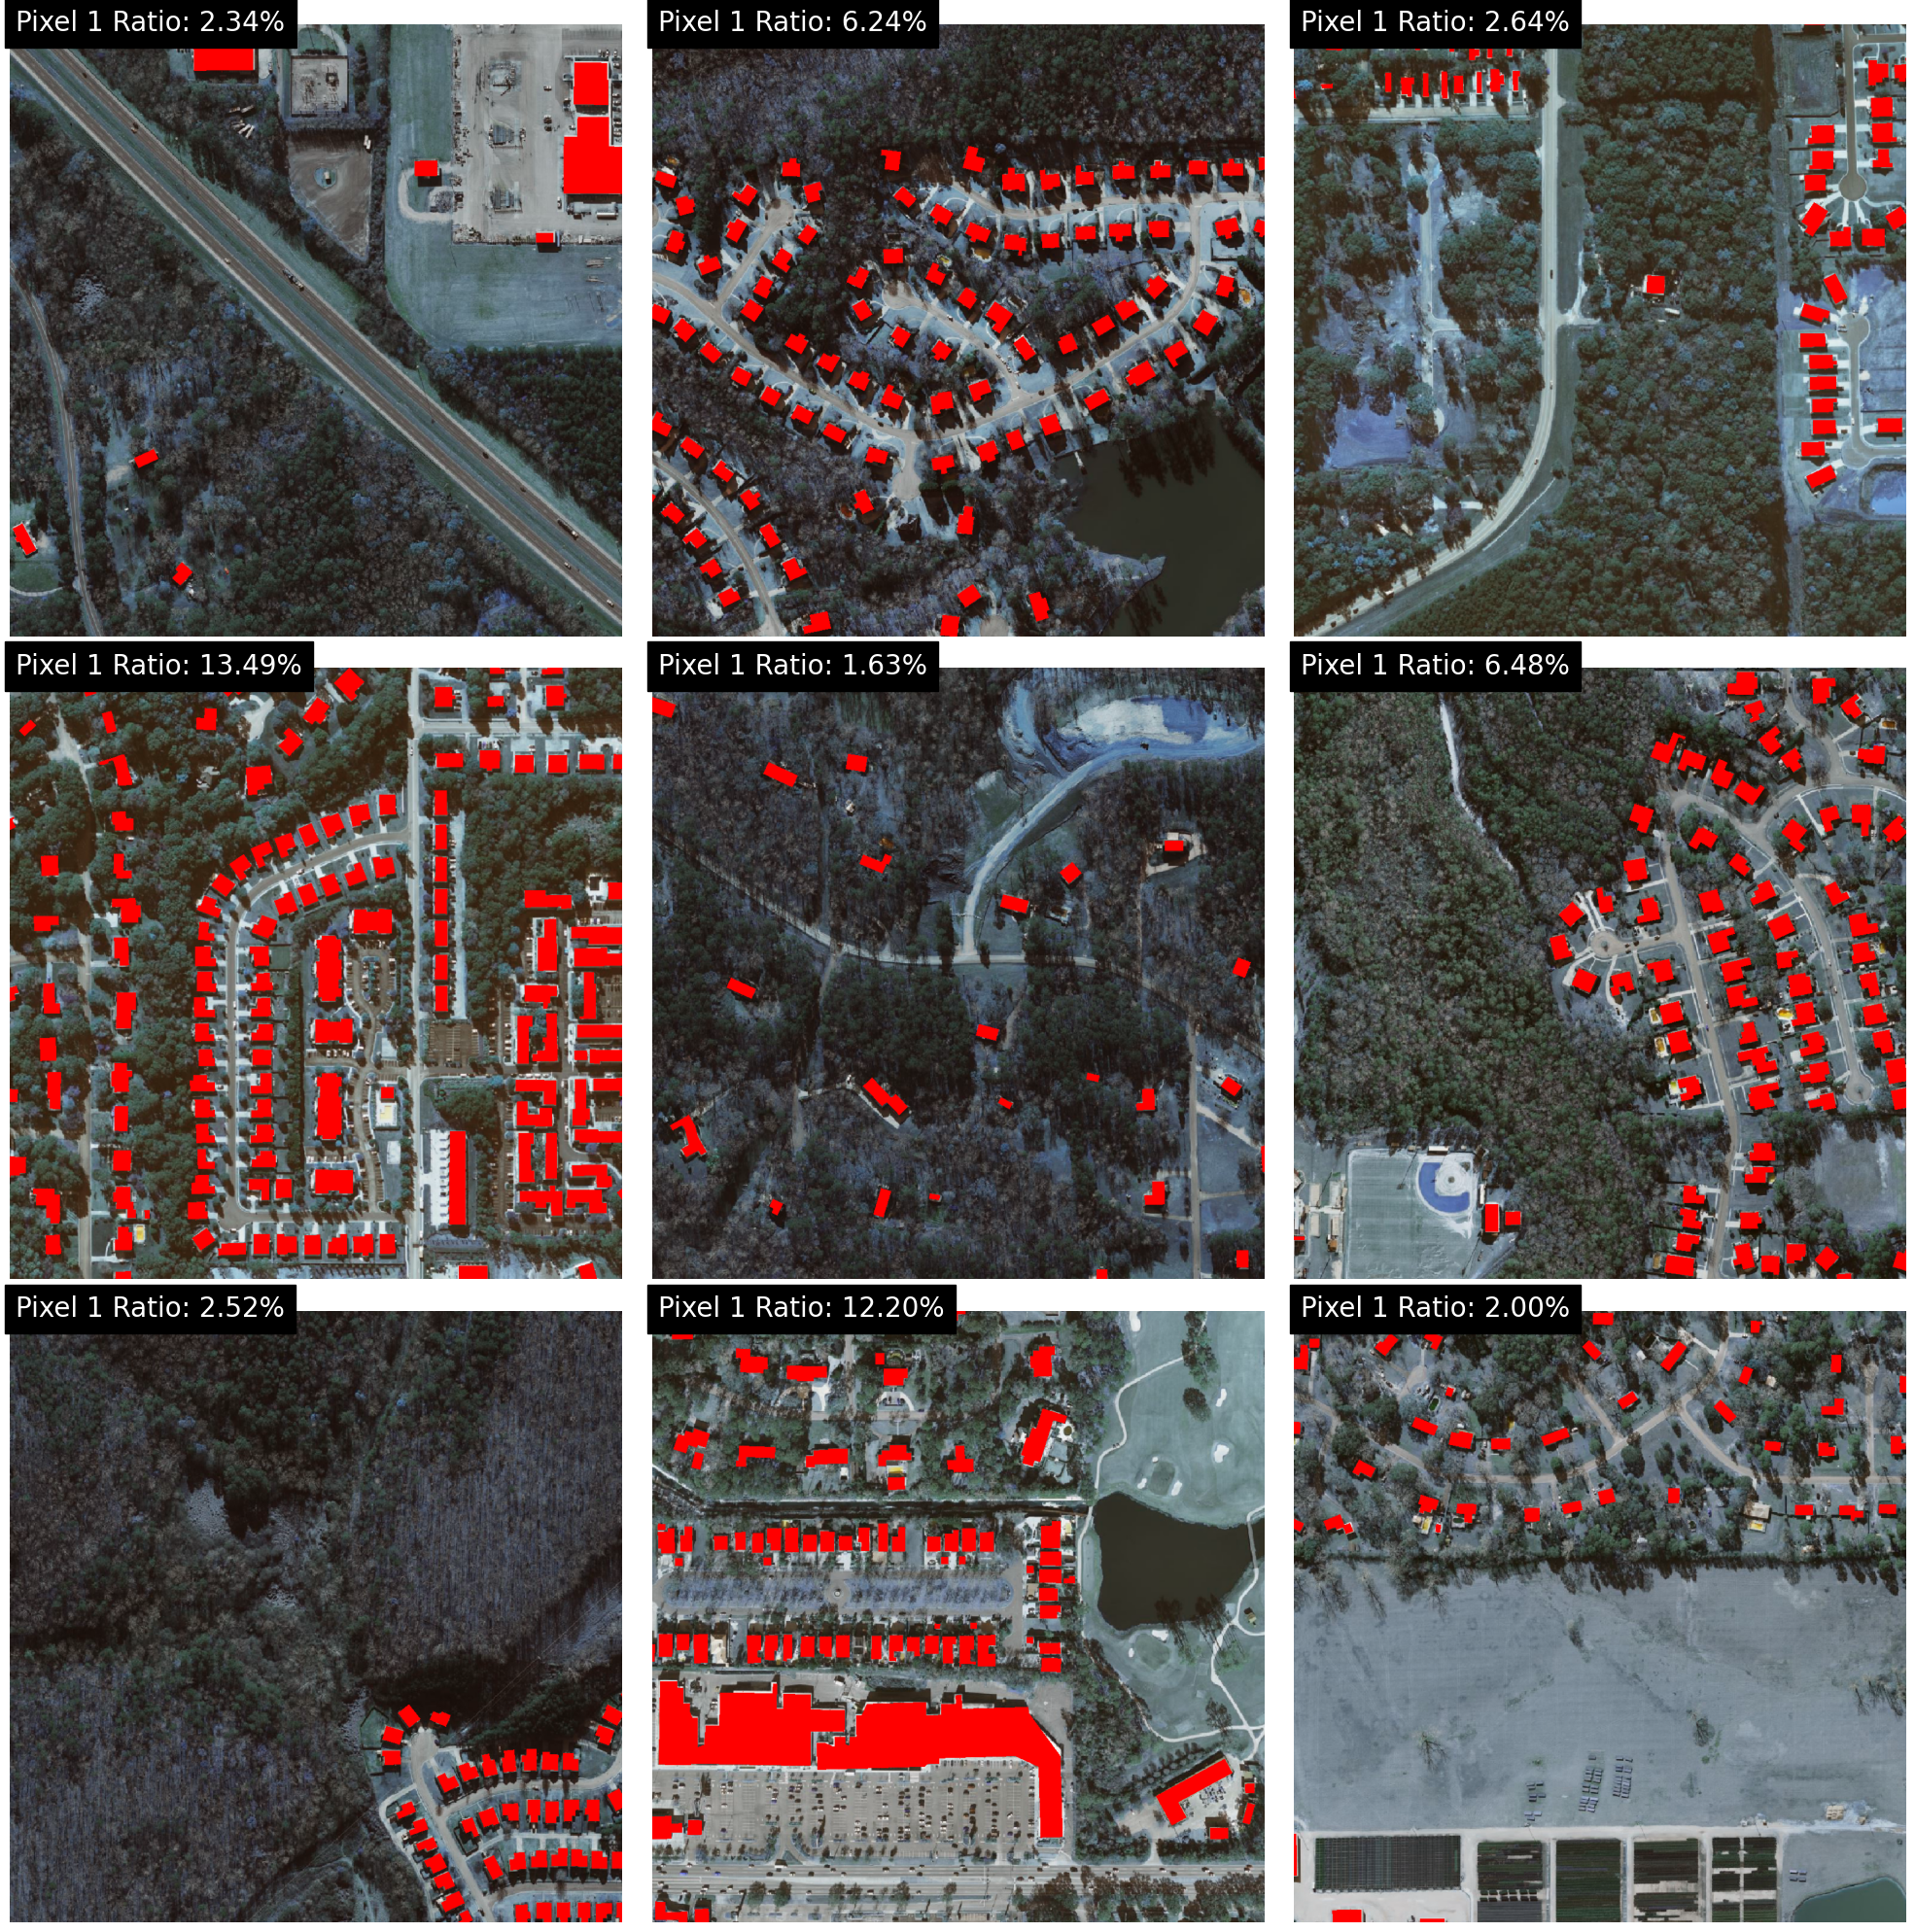

In [23]:
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize = (20, 20))
for i in range(9):
    mask_path = f'/home/jovyan/work/datasets/satellite/annotations/all_train_val/TRAIN_{str(i).zfill(4)}.png'
    img_path = f'/home/jovyan/work/datasets/satellite/images/all_train_val/TRAIN_{str(i).zfill(4)}.png'
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(img_path)
    img[mask > 0] = [255, 0, 0]
    total_pixels = mask.size
    pixel_1_count = np.count_nonzero(mask == 1)
    pixel_1_ratio = (pixel_1_count / total_pixels) * 100
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.text(10, 10, f"Pixel 1 Ratio: {pixel_1_ratio:.2f}%", color='white', backgroundcolor='black', fontsize = 20)

plt.tight_layout()
plt.show()

# 1. 건물 영역 크기

### 1) 나누기 전

In [15]:
import cv2, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

img_root = "/home/jovyan/work/datasets/satellite/annotations/all_train_val"

img_paths = []
def calculate(img_root):
    ret = []
    for img_id in tqdm(os.listdir(img_root)):
        if os.path.splitext(img_id)[1] == ".png":
            img_path = os.path.join(img_root, img_id)
            mask = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            total_pixels = 1024 * 1024    
            pixel_1_count = np.count_nonzero(mask == 1)
            pixel_1_ratio = (pixel_1_count / total_pixels) * 100
            img_paths.append(img_path)
            ret.append(int(pixel_1_ratio))
    return ret

from collections import Counter
def count(target):
    category_counts = Counter(target)
    plt.bar(category_counts.keys(), category_counts.values())
    plt.xlabel('Pixel Ratio [%]')
    plt.ylabel('.png Count')
    plt.title('HISTOGRAM')
    
    plt.text(0, -100, f"Mean: {np.mean(target):.2f}%\nStd: {np.std(target):.2f}%\nMax: {max(target):.2f}%\nMin: {min(target):.2f}%",
         color='black', backgroundcolor='white')
    plt.show()

pixel_ratios = calculate(img_root)
df = pd.DataFrame({'name' : img_paths,
                   'ratio' : pixel_ratios})
count(df['ratio'])

100%|██████████| 7140/7140 [00:38<00:00, 186.03it/s]


### 2) 건물 영역 크기를 기준으로 나누기

In [12]:
df.loc[df['ratio'] > 21, 'ratio'] = 22
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(df, stratify=df['ratio'], test_size=0.2)

### 3) 나눈 후

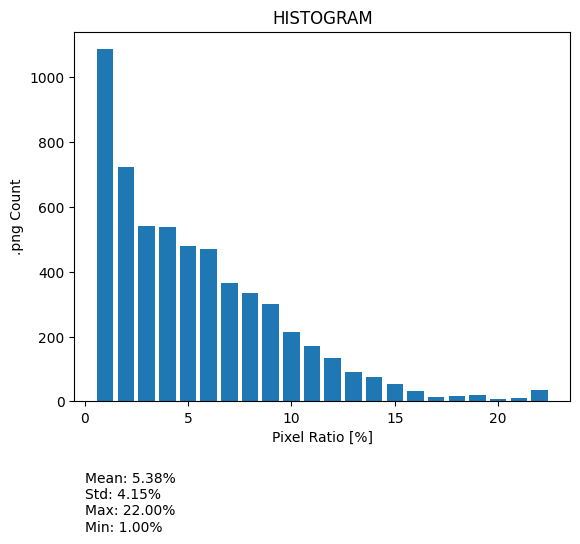

In [13]:
count(X_train['ratio'])

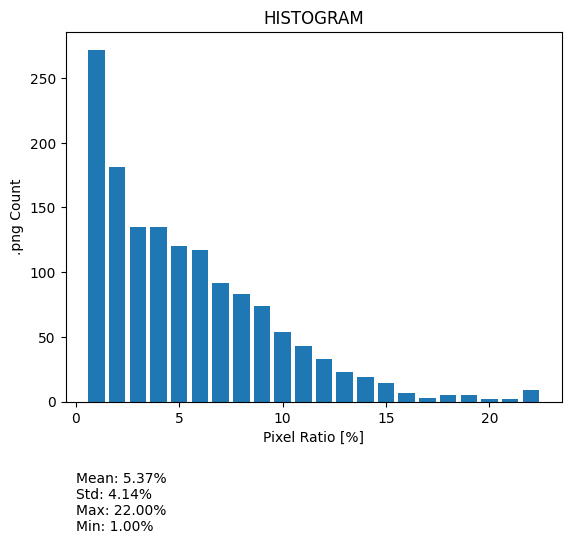

In [16]:
count(X_valid['ratio'])

# 2. 건물 영역 밀도

### 1) 나누기 전

100%|██████████| 1051/1051 [00:18<00:00, 57.44it/s]


7002  images


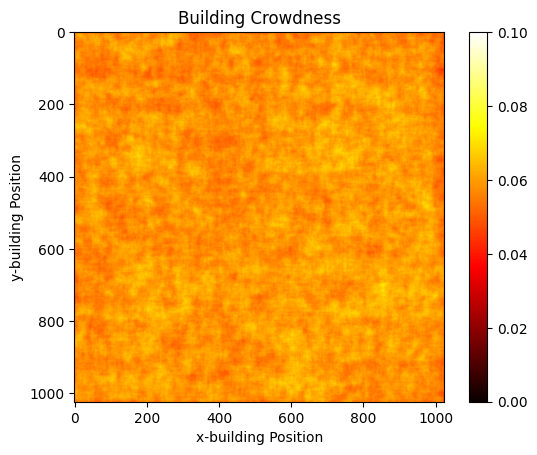

In [7]:
import cv2, os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def accumulate_pixel_positions(img_roots):
    accumulated_image = np.zeros((1024, 1024), dtype=np.float32)
    # Accumulate the pixel 1 positions for each image
    img_length = 0
    for img_root in img_roots:
        img_list = os.listdir(img_root)  
        img_length += len(img_list)
        for img_id in tqdm(img_list):
            if os.path.splitext(img_id)[1] == ".png":
                img_path = os.path.join(img_root, img_id)
                mask = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                row_indices, col_indices = np.where(mask == 1)
                accumulated_image[row_indices, col_indices] += 1
            
    normalized_image = accumulated_image / img_length
    
    # Plot the normalized image
    print(img_length, " images")
    plt.imshow(normalized_image, cmap='hot', vmin= 0, vmax=0.1)
    plt.colorbar()
    plt.title('Building Crowdness')
    plt.xlabel('x-building Position')
    plt.ylabel('y-building Position')
    plt.show()
    
img_roots = ["/home/jovyan/work/datasets/satellite3/anno_train_img",
           "/home/jovyan/work/datasets/satellite3/anno_valid_img"]
accumulate_pixel_positions(img_roots)

### 2) 나눈 후

100%|██████████| 5951/5951 [01:37<00:00, 61.17it/s]


5951  images


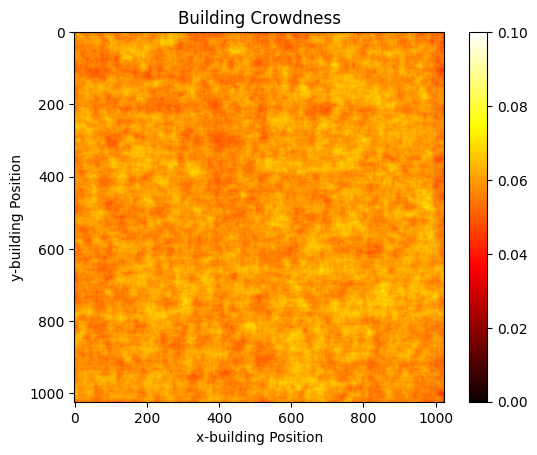

In [8]:
train_img_root = ["/home/jovyan/work/datasets/satellite3/anno_train_img"]
accumulate_pixel_positions(train_img_root)

100%|██████████| 1051/1051 [00:17<00:00, 61.01it/s]


1051  images


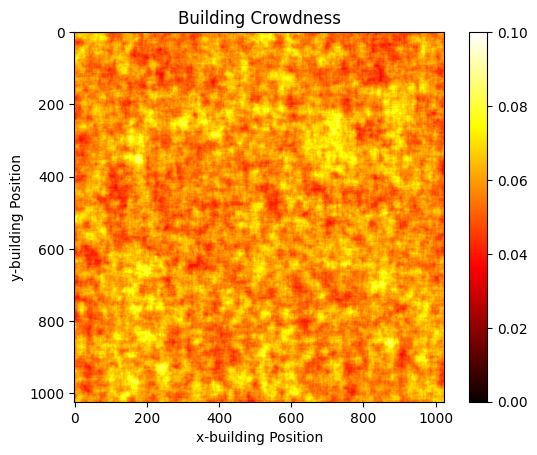

In [9]:
val_img_root = ["/home/jovyan/work/datasets/satellite3/anno_valid_img"]
accumulate_pixel_positions(val_img_root)

# 3. Histogram

### 1) 나누기 전

100%|██████████| 1051/1051 [00:31<00:00, 33.18it/s]


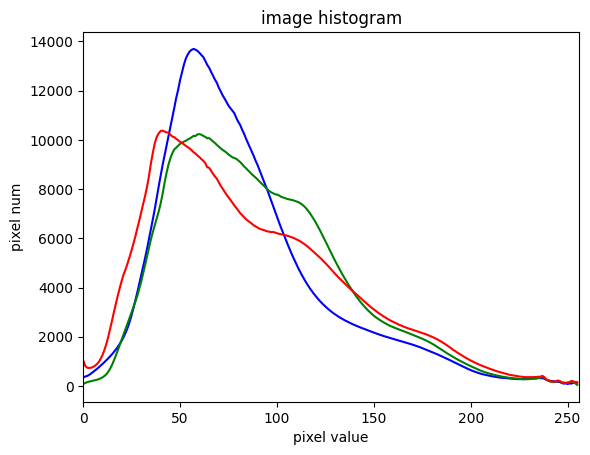

In [1]:
import cv2, os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def cal_hist(img_roots):
    hist = np.array([[0]*256 for _ in range(3)], dtype=np.float32)
    color = ('b','g','r')
    img_length = 0
    for img_root in img_roots:
        img_list = os.listdir(img_root)
        img_length += len(img_list)
        for img_id in tqdm(img_list):
            if os.path.splitext(img_id)[1] == ".png":
                img_path = os.path.join(img_root, img_id)
                img = cv2.imread(img_path)
                for i in range(3):
                    histr = cv2.calcHist([img],[i],None,[256],[0,256])
                    hist[i] += histr.reshape(-1)
    hist = hist // img_length
    for i, col in enumerate(color):
        plt.plot(hist[i],color = col)
    plt.xlim([0,256])
    plt.title('image histogram')
    plt.xlabel('pixel value')
    plt.ylabel('pixel num')
    plt.show()
    
img_roots = ["/home/jovyan/work/datasets/satellite3/train_img",
            "/home/jovyan/work/datasets/satellite3/valid_img"]
cal_hist(img_roots)

### 2) 나눈 후

100%|██████████| 5951/5951 [02:57<00:00, 33.44it/s]


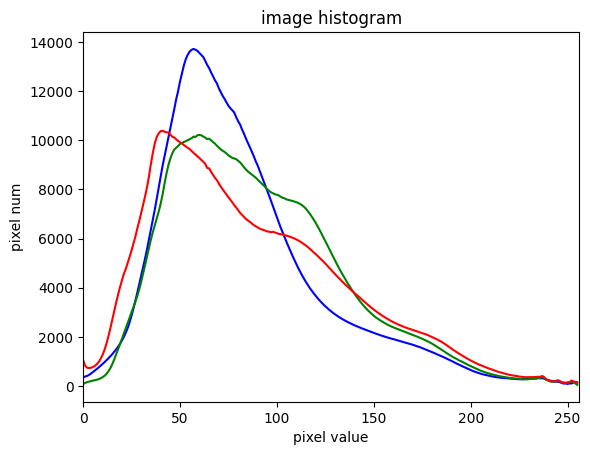

In [2]:
train_img_root = ["/home/jovyan/work/datasets/satellite3/train_img"]
cal_hist(train_img_root)

100%|██████████| 1051/1051 [00:31<00:00, 33.24it/s]


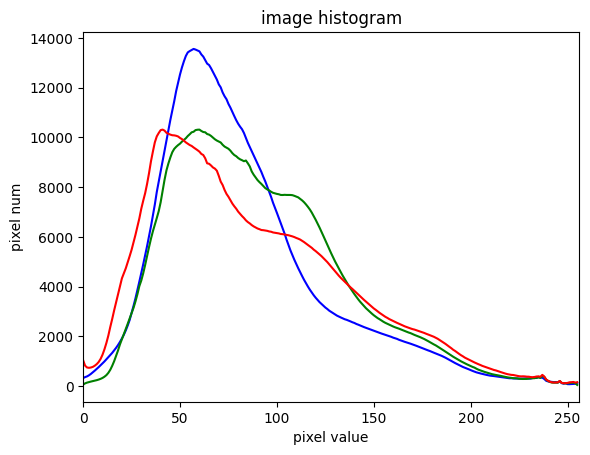

In [3]:
valid_img_root = ["/home/jovyan/work/datasets/satellite3/valid_img"]
cal_hist(valid_img_root)